# Visualize States

In [3]:
import os
import glob
import pickle
import re
import h5py, numpy as np, pandas as pd            
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from itertools import groupby
from matplotlib.ticker import MultipleLocator


✔ Saved mean activations → /home/jovyan/narratives-project/state-activation-profiles/mean_activations_k14.csv

Model with k = 14 states
AIC = 436946.4, BIC = 451738.9


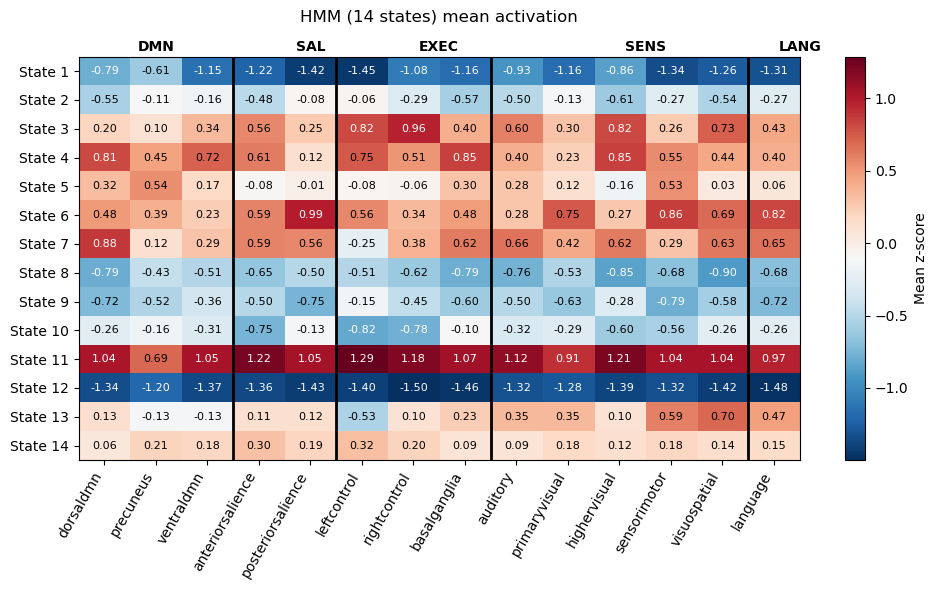

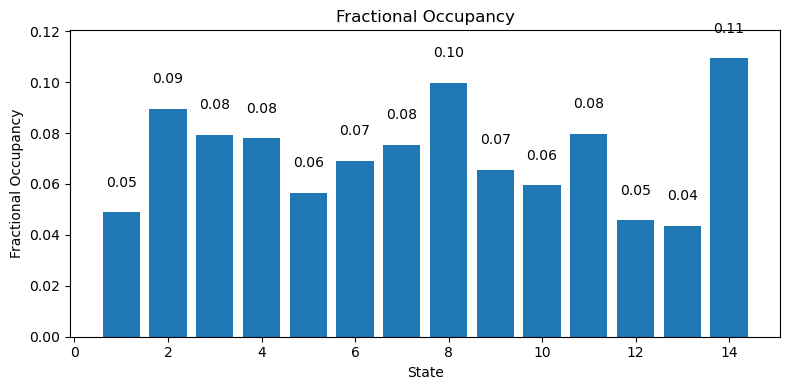

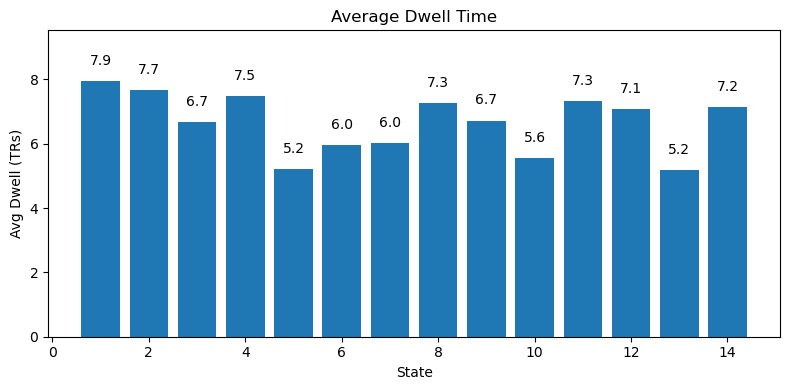


Top‑3 networks per state:
 State 1: ['precuneus', 'dorsaldmn', 'highervisual']
 State 2: ['leftcontrol', 'posteriorsalience', 'precuneus']
 State 3: ['rightcontrol', 'leftcontrol', 'highervisual']
 State 4: ['basalganglia', 'highervisual', 'dorsaldmn']
 State 5: ['precuneus', 'sensorimotor', 'dorsaldmn']
 State 6: ['posteriorsalience', 'sensorimotor', 'language']
 State 7: ['dorsaldmn', 'auditory', 'language']
 State 8: ['precuneus', 'posteriorsalience', 'ventraldmn']
 State 9: ['leftcontrol', 'highervisual', 'ventraldmn']
 State 10: ['basalganglia', 'posteriorsalience', 'precuneus']
 State 11: ['leftcontrol', 'anteriorsalience', 'highervisual']
 State 12: ['precuneus', 'primaryvisual', 'auditory']
 State 13: ['visuospatial', 'sensorimotor', 'language']
 State 14: ['leftcontrol', 'anteriorsalience', 'precuneus']

Fractional occupancy per state:
 State 1: 0.049
 State 2: 0.089
 State 3: 0.079
 State 4: 0.078
 State 5: 0.056
 State 6: 0.069
 State 7: 0.075
 State 8: 0.100
 State 9: 0.06

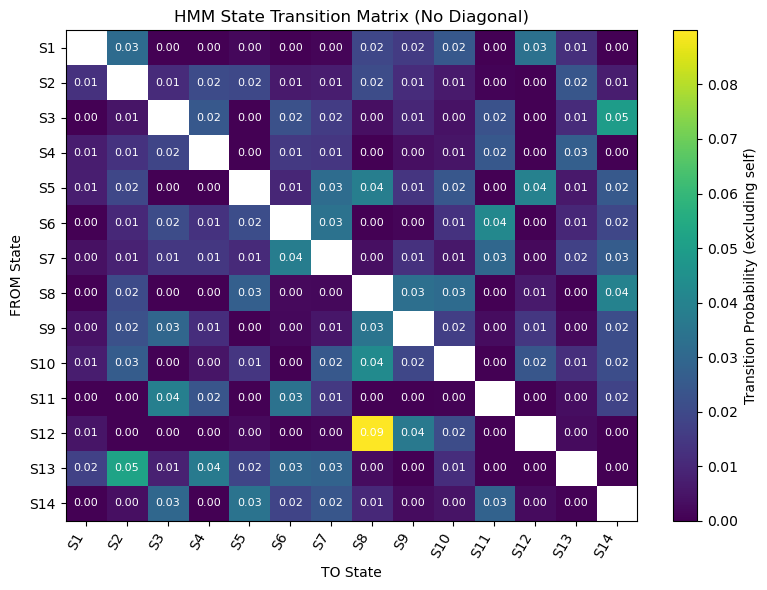

In [4]:
# ─── SETTINGS ─────────────────────────────────────────────────────
INPUT_DIR = "/home/jovyan/narratives-project/shirer-components"
PKL_DIR   = "/home/jovyan/narratives-project/hmm-objects"
DATASET   = "timeseries"
# ──────────────────────────────────────────────────────────────────

def load_and_normalize_h5_files(input_dir, dataset_name=DATASET):
    """Return a list of z‑scored network‑level arrays (timepoints × networks)."""
    files = sorted(glob.glob(os.path.join(input_dir, "*.h5")))
    if not files:
        raise FileNotFoundError(f"No .h5 files in {input_dir}")

    data_list = []
    for fp in files:
        with h5py.File(fp, "r") as f:
            arr = f[dataset_name][()]
        data_list.append(StandardScaler().fit_transform(arr.T))
    return data_list


def get_network_names(input_dir):
    """Pull the network labels from the first Shirer .h5 file."""
    files = sorted(glob.glob(os.path.join(input_dir, "*.h5")))
    if not files:
        raise FileNotFoundError("No .h5 files to read network names")
    with h5py.File(files[0], "r") as f:
        raw = f["network"][()]
    return [b.decode() if isinstance(b, (bytes, bytearray)) else str(b) for b in raw]

# ─── VISUALIZATION HELPERS ───────────────────────────────────────

def plot_transition_heatmap(transmat):
    K = transmat.shape[0]
    mat = transmat.copy(); np.fill_diagonal(mat, np.nan)
    plt.figure(figsize=(8, 6))
    im = plt.imshow(mat, aspect="auto", cmap="viridis")
    plt.colorbar(im, label="Transition Probability (excluding self)")
    plt.xticks(range(K), [f"S{i+1}" for i in range(K)], rotation=60, ha="right")
    plt.yticks(range(K), [f"S{i+1}" for i in range(K)])
    plt.xlabel("TO State"); plt.ylabel("FROM State")
    for i in range(K):
        for j in range(K):
            if i != j:
                plt.text(j, i, f"{transmat[i, j]:.2f}", ha="center", va="center", fontsize=8, color="white")
    plt.title("HMM State Transition Matrix (No Diagonal)"); plt.tight_layout(); plt.show()


def visualize_states(model, concat_data, network_names):
    if not hasattr(model, "means_"):
        raise TypeError("Provided object is not an HMM model (missing 'means_').")

    K, _ = model.means_.shape; means = model.means_

    fam_order = [
        "dorsaldmn", "precuneus", "ventraldmn",
        "anteriorsalience", "posteriorsalience",
        "leftcontrol", "rightcontrol", "basalganglia",
        "auditory", "primaryvisual", "highervisual", "sensorimotor", "visuospatial",
        "language",
    ]
    idx_map = {n: i for i, n in enumerate(network_names)}
    reordered_idx = [idx_map[n] for n in fam_order if n in idx_map]
    labels = [n for n in fam_order if n in idx_map]
    means_reordered = means[:, reordered_idx]

    # heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(means_reordered, aspect="auto", cmap="RdBu_r", vmin=means.min(), vmax=means.max())
    ax.set_yticks(range(K)); ax.set_yticklabels([f"State {i+1}" for i in range(K)])
    ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=60, ha="right")
    plt.colorbar(im, ax=ax, label="Mean z‑score"); ax.set_title(f"HMM ({K} states) mean activation", pad=25)
    for i in range(K):
        for j, lbl in enumerate(labels):
            val = means_reordered[i, j]
            color = "black" if abs(val) < (means.max() * 0.6) else "white"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color=color)
    # family separators & labels
    fam_sizes = [3, 2, 3, 5, 1]; cum = np.cumsum(fam_sizes)
    for b in cum[:-1]:
        ax.axvline(b - 0.5, color="k", lw=2)
    for i, grp in enumerate(["DMN", "SAL", "EXEC", "SENS", "LANG"]):
        mid = (cum[i] + cum[i-1] if i > 0 else (cum[0]-1)) / 2
        ax.text(mid, -0.6, grp, ha="center", va="bottom", fontsize=10, fontweight="bold", transform=ax.transData)
    plt.tight_layout(); plt.show()

    # fractional occupancy & dwell time
    seq = model.predict(concat_data)
    occ = np.bincount(seq, minlength=K) / len(seq)
    plt.figure(figsize=(8, 4)); bars = plt.bar(range(1, K+1), occ)
    plt.xlabel("State"); plt.ylabel("Fractional Occupancy"); plt.ylim(0, occ.max()*1.1)
    for i, b in enumerate(bars): plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.01, f"{occ[i]:.2f}", ha="center")
    plt.title("Fractional Occupancy"); plt.tight_layout(); plt.show()

    dwell = {s: [] for s in range(K)}
    for s, grp in groupby(seq): dwell[s].append(len(list(grp)))
    avg_dwell = [np.mean(dwell[s]) if dwell[s] else 0 for s in range(K)]
    plt.figure(figsize=(8, 4)); bars = plt.bar(range(1, K+1), avg_dwell)
    plt.xlabel("State"); plt.ylabel("Avg Dwell (TRs)"); plt.ylim(0, max(avg_dwell)*1.2)
    for i, b in enumerate(bars): plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.5, f"{avg_dwell[i]:.1f}", ha="center")
    plt.title("Average Dwell Time"); plt.tight_layout(); plt.show()

    print("\nTop‑3 networks per state:")
    for i, m in enumerate(means):
        best = np.argsort(m)[-3:][::-1]
        print(f" State {i+1}: {[network_names[j] for j in best]}")
    print("\nFractional occupancy per state:")
    for i, o in enumerate(occ):
        print(f" State {i+1}: {o:.3f}")
    print("\nState transition matrix:")
    print(np.round(model.transmat_, 3))
    plot_transition_heatmap(model.transmat_)

# ─── MAIN ─────────────────────────────────────────────────────────

def select_best_from_list(obj_list):
    """Pick the entry with the lowest AIC (if present) or highest logL."""
    candidates = [d for d in obj_list if isinstance(d, dict) and "model" in d]
    if not candidates:
        raise ValueError("List does not contain any dicts with a 'model' key")
    if "AIC" in candidates[0]:
        return min(candidates, key=lambda d: d.get("AIC", np.inf))
    return max(candidates, key=lambda d: d.get("logL", -np.inf))


# ─── Utility to save mean-activation CSV ──────────────────────────
def save_mean_activations_csv(model, network_names, out_dir, k):
    """
    Dump a CSV: rows = states, cols = <network>_mean_activation.
    """
    means = model.means_                             # shape (K, N)
    df = pd.DataFrame(
        means,
        columns=[f"{n}_mean_activation" for n in network_names],
        index=[f"State_{i+1}" for i in range(means.shape[0])]
    )
    os.makedirs(out_dir, exist_ok=True)
    csv_path = os.path.join(out_dir, f"mean_activations_k{k}.csv")
    df.to_csv(csv_path)
    print(f"✔ Saved mean activations → {csv_path}")

# ─── MAIN (only the loop body changes) ────────────────────────────
def main():
    data_list = load_and_normalize_h5_files(INPUT_DIR)
    concat = np.vstack(data_list)
    network_names = get_network_names(INPUT_DIR)

    pkl_files = sorted(glob.glob(os.path.join(PKL_DIR, "*.pkl")))
    if not pkl_files:
        raise FileNotFoundError(f"No .pkl files in {PKL_DIR}")

    OUT_DIR = "/home/jovyan/narratives-project/state-activation-profiles"

    for pkl_fp in pkl_files:
        base = os.path.basename(pkl_fp)
        m = re.search(r"k(\d+)", base)
        k_hint = int(m.group(1)) if m else None
        with open(pkl_fp, "rb") as f:
            obj = pickle.load(f)

        # unwrap list-style pickles (unchanged) …
        if isinstance(obj, list):
            try:
                best = select_best_from_list(obj)
                model, aic, bic, k = best["model"], best.get("AIC"), best.get("BIC"), best.get("k", k_hint)
            except Exception as e:
                print(f"[WARN] Skipping {base}: {e}")
                continue
        elif isinstance(obj, dict) and "model" in obj:
            model, aic, bic, k = obj["model"], obj.get("AIC"), obj.get("BIC"), obj.get("k", k_hint)
        else:
            model, aic, bic, k = obj, None, None, k_hint

        if not hasattr(model, "means_"):
            print(f"[WARN] Object in {base} is not an HMM model. Skipping.")
            continue

        # NEW: save CSV of mean activations
        save_mean_activations_csv(model, network_names, OUT_DIR, k)

        # existing visualization and printing
        print("\n" + "="*60)
        print(f"Model with k = {k} states")
        if aic is not None and bic is not None:
            print(f"AIC = {aic:.1f}, BIC = {bic:.1f}")
        visualize_states(model, concat, network_names)

if __name__ == "__main__":
    main() 